# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4517.dev0+g57af362
2.9.0


`caseH` is the start time [H] of the co-simulation, now 10 and 18 are supported.

In [2]:
caseH = 18
ict_off = False
ecc_off = False

%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7726
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=-0.0
Ctrl: 0=7897; 1=6580; 
EVA: Load A from Aest.csv.
Working directory: "/home/jwang175/andes/jwang/notes"
> Loaded config from file "/home/jwang175/.andes/andes.rc"
> Loaded generated Python code in "/home/jwang175/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 6 processes.


Saved generated pycode to "/home/jwang175/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.3034 seconds.
Parsing input file "/home/jwang175/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.1175 seconds.
System internal structure set up in 0.0784 seconds.


## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


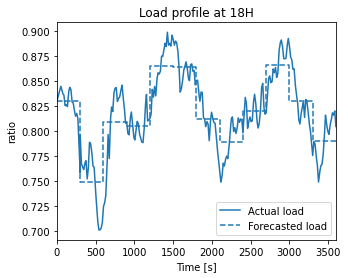

In [3]:
%run -i 'cosim_loadsyn.py'

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [4]:
%run -i 'cosim_setup_dispatch.py'
dc_comp.round(4)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1338 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0116 seconds.
Power flow results are consistent. Conversion is successful.


Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0181 seconds.
0: |F(x)| = 9.101680411
1: |F(x)| = 3.497456414
2: |F(x)| = 0.1830766454
3: |F(x)| = 0.0007183029104
4: |F(x)| = 1.659286886e-08
Converged in 5 iterations in 0.0133 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4889.131


pp cost=2184.5741560778915, gb cost=4889.131241556355


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,970.0313,39.9756,15.8831,1.0,970.0312
1,646.0000,228.9208,2.2281,1.0,646.0000
2,290.0000,81.0987,-0.8653,1.0,290.0000
3,652.0000,114.2245,7.2985,1.0,652.0000
4,508.0000,137.9576,5.4672,1.0,508.0000
5,646.6875,212.0871,6.4196,1.0,646.6875
6,232.0000,55.2884,3.4379,1.0,232.0000
7,564.0000,-59.8950,13.9534,1.0,564.0000
8,865.0000,49.8766,18.9462,1.0,865.0000
9,30.0000,49.8766,18.9462,1.0,30.0000


## Prepare

### Make link table

In [5]:
%run -i 'cosim_linktable.py'
ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,rg_idx,rexc_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,False,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,False,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,False,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,False,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,False,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,False,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,False,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,False,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,False,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,False,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [6]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 900

rru, rrd, rsfr = 1.0, 1.0, 0.05

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Check convergence

In [7]:
# %run -i 'cosim_bmain.py'

Loop

In [8]:
%run -i 'cosim_main.py'

RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED is solved.
RTED: total cost=4703.628
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0087 seconds.
0: |F(x)| = 7.905038032
1: |F(x)| = 3.815590932
2: |F(x)| = 0.2217099894
3: |F(x)| = 0.001778348784
4: |F(x)| = 7.760537057e-08
Converged in 5 iterations in 0.0156 seconds.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.014  | 0.001
 GENROU_3  | 0.018  | 0.003
 GENROU_4  | 0.013  | 0.001
 GENROU_5  | 0.014  | 0.001
 GENROU_7  | 0.015  | 0.002
 GENROU_8  | 0.015  | 0.006
 GENROU_9  | 0.009  | 0.001
 GENROU_10 | 0.013  | 0.000


Initialization for

Simulation to t=124.00 sec completed in 0.0742 seconds.
Simulation to t=125.00 sec completed in 0.0731 seconds.
Simulation to t=126.00 sec completed in 0.0773 seconds.
Simulation to t=127.00 sec completed in 0.0814 seconds.
Simulation to t=128.00 sec completed in 0.0734 seconds.
Simulation to t=129.00 sec completed in 0.0728 seconds.
Simulation to t=130.00 sec completed in 0.0753 seconds.
Simulation to t=131.00 sec completed in 0.0712 seconds.
Simulation to t=132.00 sec completed in 0.0744 seconds.
Simulation to t=133.00 sec completed in 0.0766 seconds.
Simulation to t=134.00 sec completed in 0.0858 seconds.
Simulation to t=135.00 sec completed in 0.0769 seconds.
Simulation to t=136.00 sec completed in 0.0769 seconds.
Simulation to t=137.00 sec completed in 0.0805 seconds.
Simulation to t=138.00 sec completed in 0.0773 seconds.
Simulation to t=139.00 sec completed in 0.0737 seconds.
Simulation to t=140.00 sec completed in 0.0760 seconds.
Simulation to t=141.00 sec completed in 0.0732 s

Simulation to t=271.00 sec completed in 0.1250 seconds.
Simulation to t=272.00 sec completed in 0.0858 seconds.
Simulation to t=273.00 sec completed in 0.0841 seconds.
Simulation to t=274.00 sec completed in 0.0833 seconds.
Simulation to t=275.00 sec completed in 0.0906 seconds.
Simulation to t=276.00 sec completed in 0.1068 seconds.
Simulation to t=277.00 sec completed in 0.1005 seconds.
Simulation to t=278.00 sec completed in 0.0948 seconds.
Simulation to t=279.00 sec completed in 0.0891 seconds.
Simulation to t=280.00 sec completed in 0.1023 seconds.
Simulation to t=281.00 sec completed in 0.1023 seconds.
Simulation to t=282.00 sec completed in 0.0986 seconds.
Simulation to t=283.00 sec completed in 0.0885 seconds.
Simulation to t=284.00 sec completed in 0.1050 seconds.
Simulation to t=285.00 sec completed in 0.1031 seconds.
Simulation to t=286.00 sec completed in 0.1001 seconds.
Simulation to t=287.00 sec completed in 0.0977 seconds.
Simulation to t=288.00 sec completed in 0.1041 s

Simulation to t=417.00 sec completed in 0.1090 seconds.
Simulation to t=418.00 sec completed in 0.1027 seconds.
Simulation to t=419.00 sec completed in 0.1051 seconds.
Simulation to t=420.00 sec completed in 0.1181 seconds.
Simulation to t=421.00 sec completed in 0.1063 seconds.
Simulation to t=422.00 sec completed in 0.1040 seconds.
Simulation to t=423.00 sec completed in 0.1039 seconds.
Simulation to t=424.00 sec completed in 0.1056 seconds.
Simulation to t=425.00 sec completed in 0.1050 seconds.
Simulation to t=426.00 sec completed in 0.1033 seconds.
Simulation to t=427.00 sec completed in 0.1013 seconds.
Simulation to t=428.00 sec completed in 0.1016 seconds.
Simulation to t=429.00 sec completed in 0.1157 seconds.
Simulation to t=430.00 sec completed in 0.1036 seconds.
Simulation to t=431.00 sec completed in 0.1052 seconds.
Simulation to t=432.00 sec completed in 0.1070 seconds.
Simulation to t=433.00 sec completed in 0.1027 seconds.
Simulation to t=434.00 sec completed in 0.1049 s

Simulation to t=564.00 sec completed in 0.0731 seconds.
Simulation to t=565.00 sec completed in 0.0930 seconds.
Simulation to t=566.00 sec completed in 0.0781 seconds.
Simulation to t=567.00 sec completed in 0.0779 seconds.
Simulation to t=568.00 sec completed in 0.0822 seconds.
Simulation to t=569.00 sec completed in 0.0754 seconds.
Simulation to t=570.00 sec completed in 0.0759 seconds.
Simulation to t=571.00 sec completed in 0.0851 seconds.
Simulation to t=572.00 sec completed in 0.0774 seconds.
Simulation to t=573.00 sec completed in 0.0759 seconds.
Simulation to t=574.00 sec completed in 0.0733 seconds.
Simulation to t=575.00 sec completed in 0.0717 seconds.
Simulation to t=576.00 sec completed in 0.0744 seconds.
Simulation to t=577.00 sec completed in 0.0777 seconds.
Simulation to t=578.00 sec completed in 0.0731 seconds.
Simulation to t=579.00 sec completed in 0.0779 seconds.
Simulation to t=580.00 sec completed in 0.0803 seconds.
Simulation to t=581.00 sec completed in 0.0742 s

Simulation to t=710.00 sec completed in 0.0910 seconds.
Simulation to t=711.00 sec completed in 0.0808 seconds.
Simulation to t=712.00 sec completed in 0.0900 seconds.
Simulation to t=713.00 sec completed in 0.1011 seconds.
Simulation to t=714.00 sec completed in 0.0934 seconds.
Simulation to t=715.00 sec completed in 0.0812 seconds.
Simulation to t=716.00 sec completed in 0.0854 seconds.
Simulation to t=717.00 sec completed in 0.0894 seconds.
Simulation to t=718.00 sec completed in 0.0987 seconds.
Simulation to t=719.00 sec completed in 0.0832 seconds.
Simulation to t=720.00 sec completed in 0.0829 seconds.
Simulation to t=721.00 sec completed in 0.1117 seconds.
Simulation to t=722.00 sec completed in 0.1046 seconds.
Simulation to t=723.00 sec completed in 0.0843 seconds.
Simulation to t=724.00 sec completed in 0.1128 seconds.
Simulation to t=725.00 sec completed in 0.0918 seconds.
Simulation to t=726.00 sec completed in 0.0823 seconds.
Simulation to t=727.00 sec completed in 0.0809 s

Simulation to t=857.00 sec completed in 0.1041 seconds.
Simulation to t=858.00 sec completed in 0.0980 seconds.
Simulation to t=859.00 sec completed in 0.0941 seconds.
Simulation to t=860.00 sec completed in 0.1049 seconds.
Simulation to t=861.00 sec completed in 0.0999 seconds.
Simulation to t=862.00 sec completed in 0.1040 seconds.
Simulation to t=863.00 sec completed in 0.0908 seconds.
Simulation to t=864.00 sec completed in 0.1044 seconds.
Simulation to t=865.00 sec completed in 0.1072 seconds.
Simulation to t=866.00 sec completed in 0.1070 seconds.
Simulation to t=867.00 sec completed in 0.0994 seconds.
Simulation to t=868.00 sec completed in 0.1020 seconds.
Simulation to t=869.00 sec completed in 0.1036 seconds.
Simulation to t=870.00 sec completed in 0.0976 seconds.
Simulation to t=871.00 sec completed in 0.0841 seconds.
Simulation to t=872.00 sec completed in 0.1127 seconds.
Simulation to t=873.00 sec completed in 0.0756 seconds.
Simulation to t=874.00 sec completed in 0.0720 s

In [9]:
ssa.exit_code

0

(<Figure size 3600x1800 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


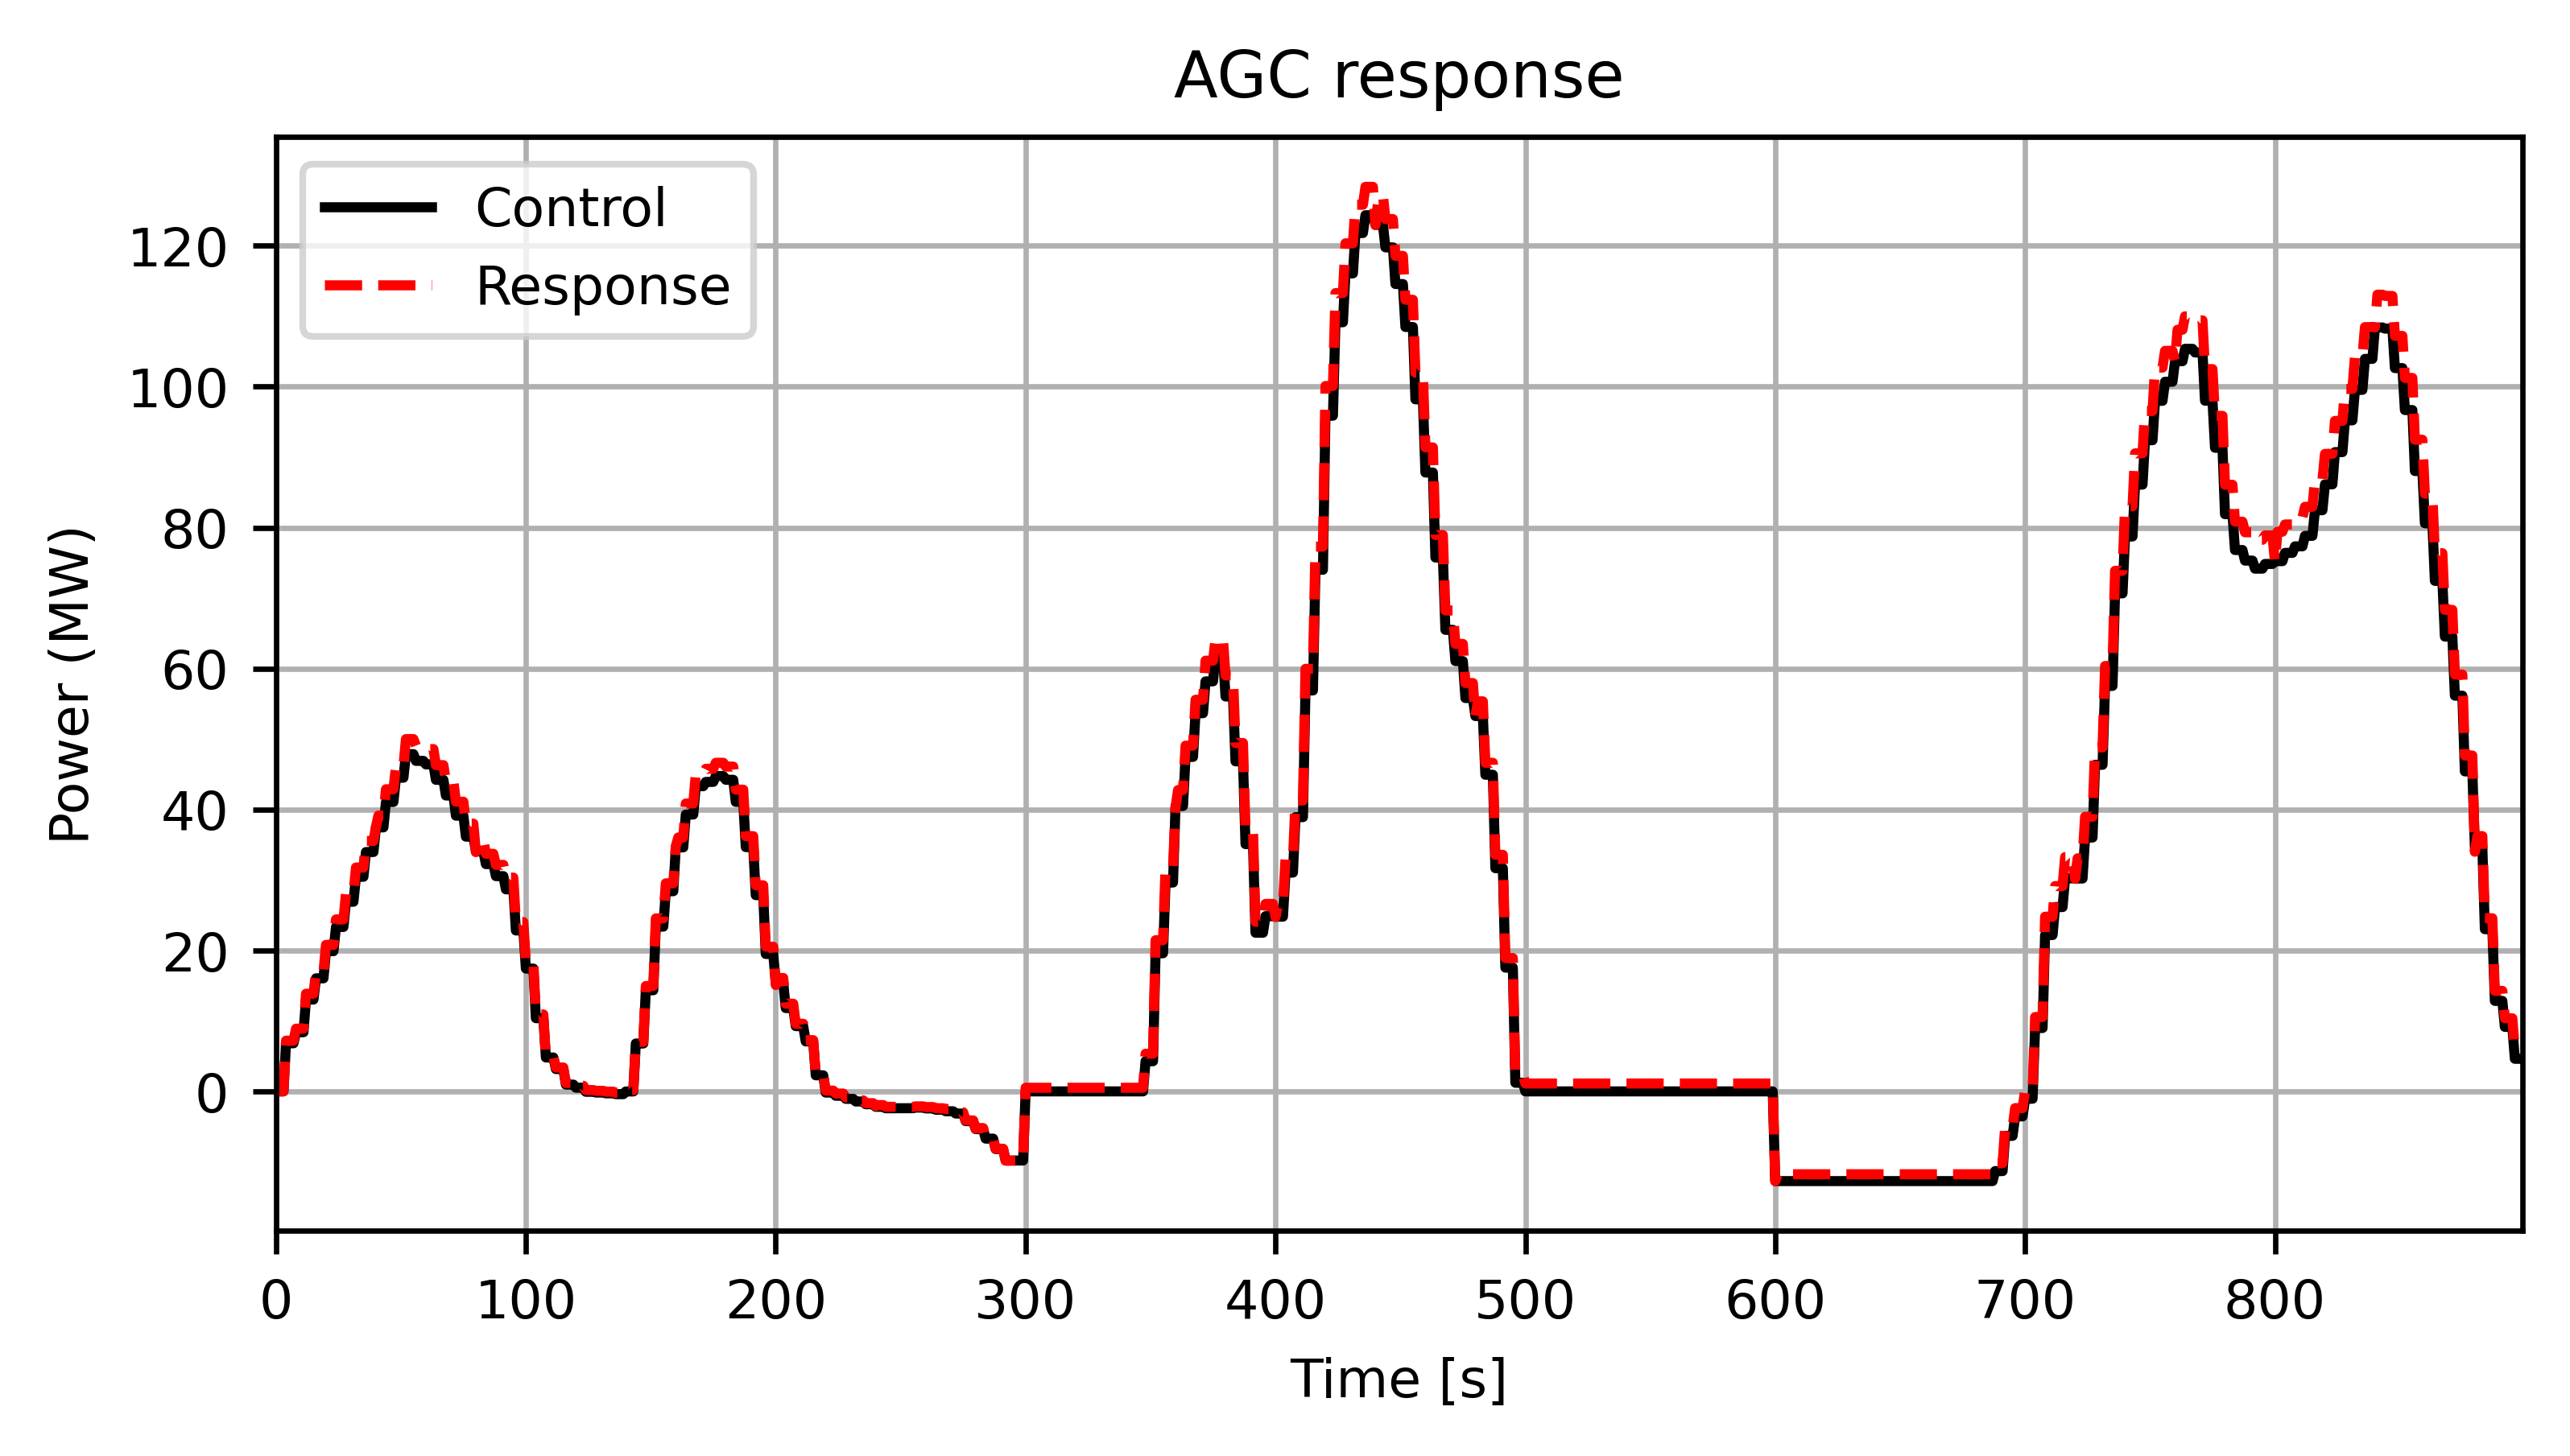

In [10]:
sse.plot_agc(style='ieee')

<AxesSubplot:>

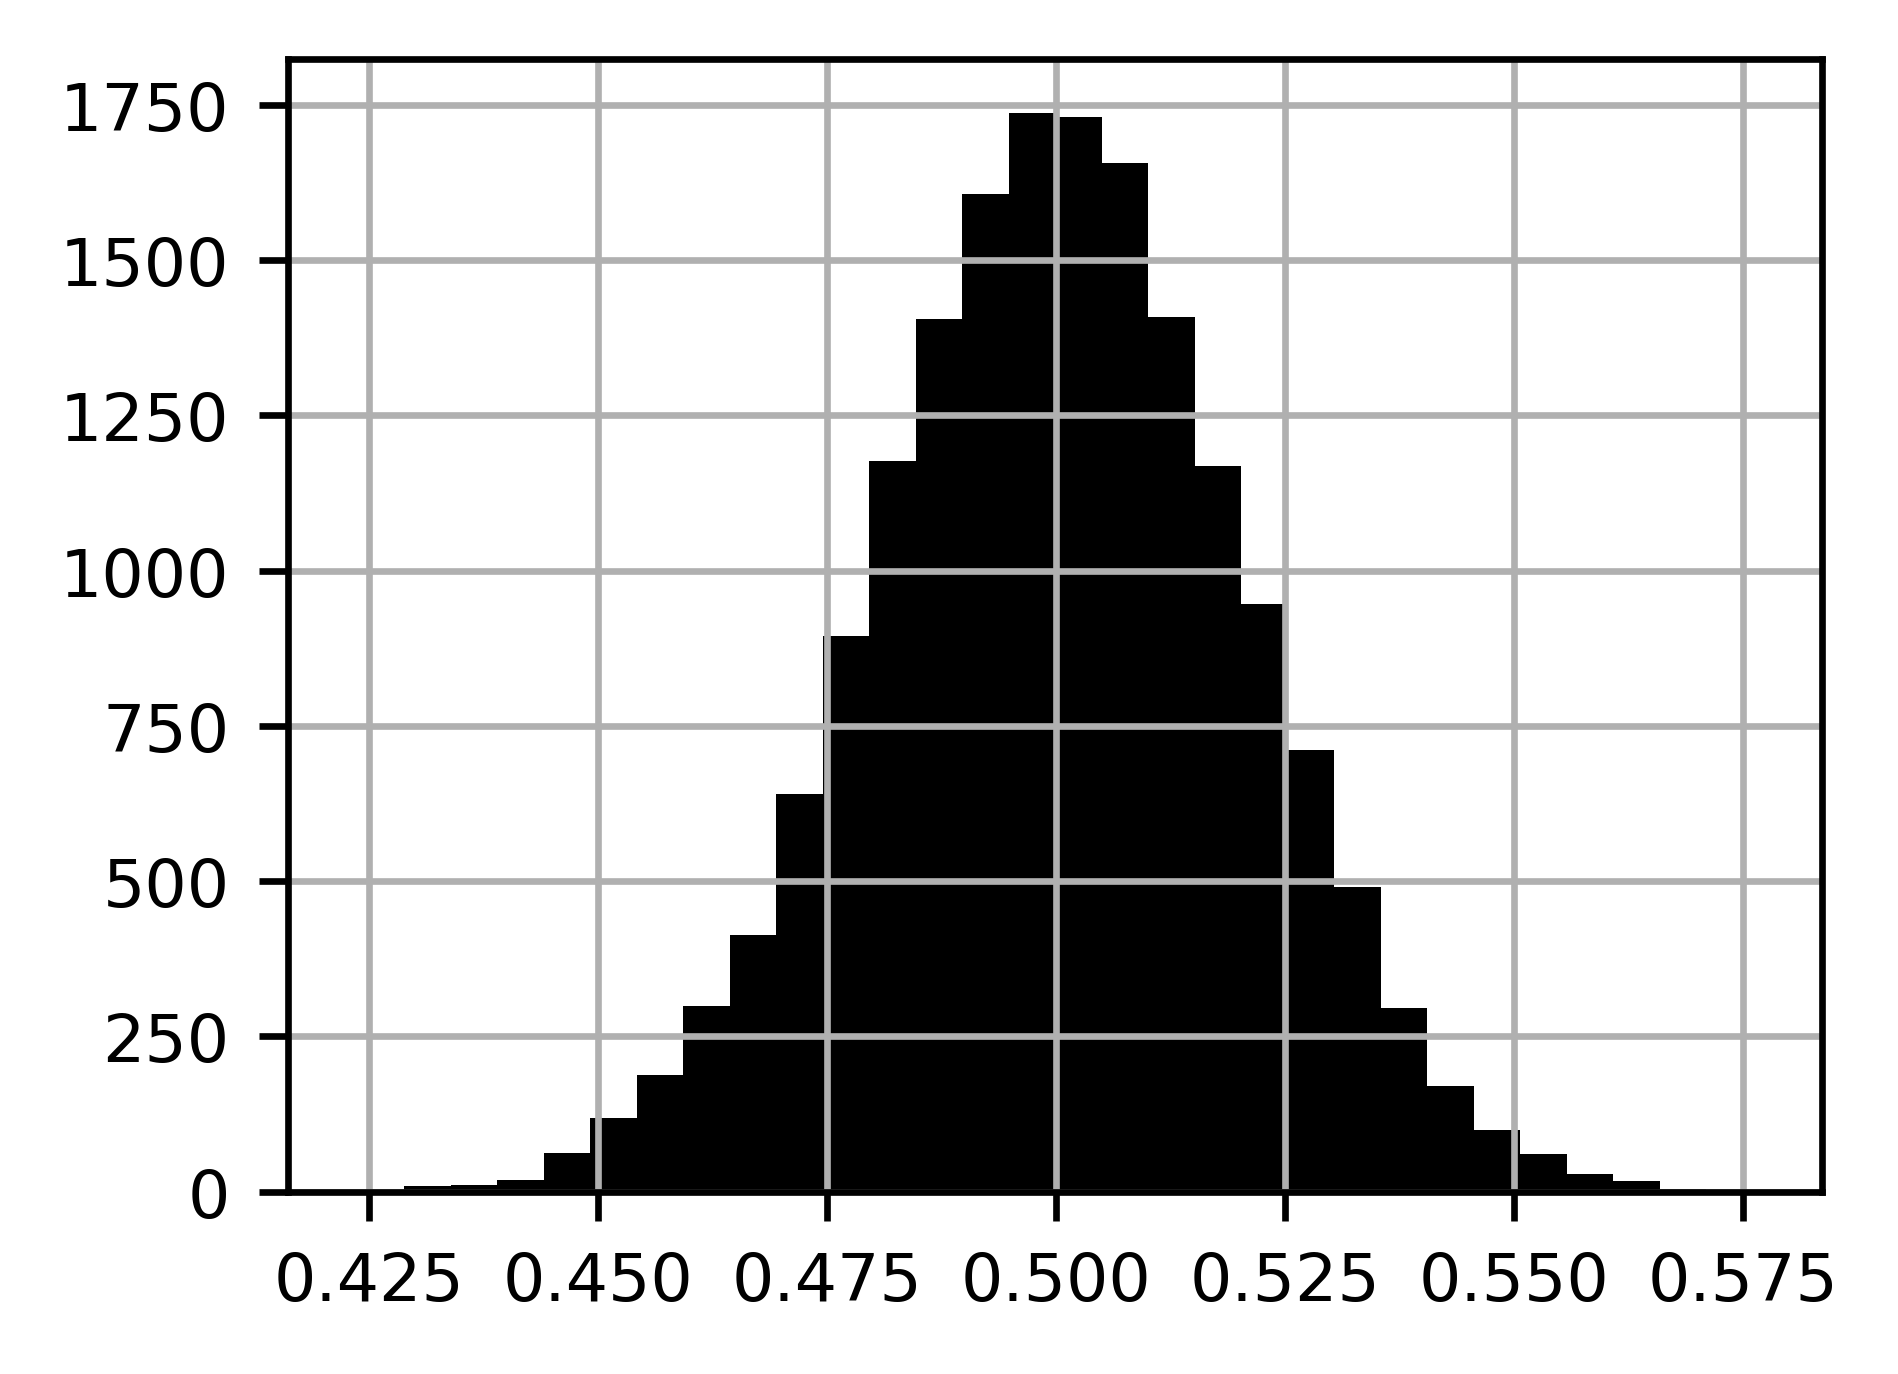

In [11]:
sse.ev["tt"].hist(bins=30)

<AxesSubplot:>

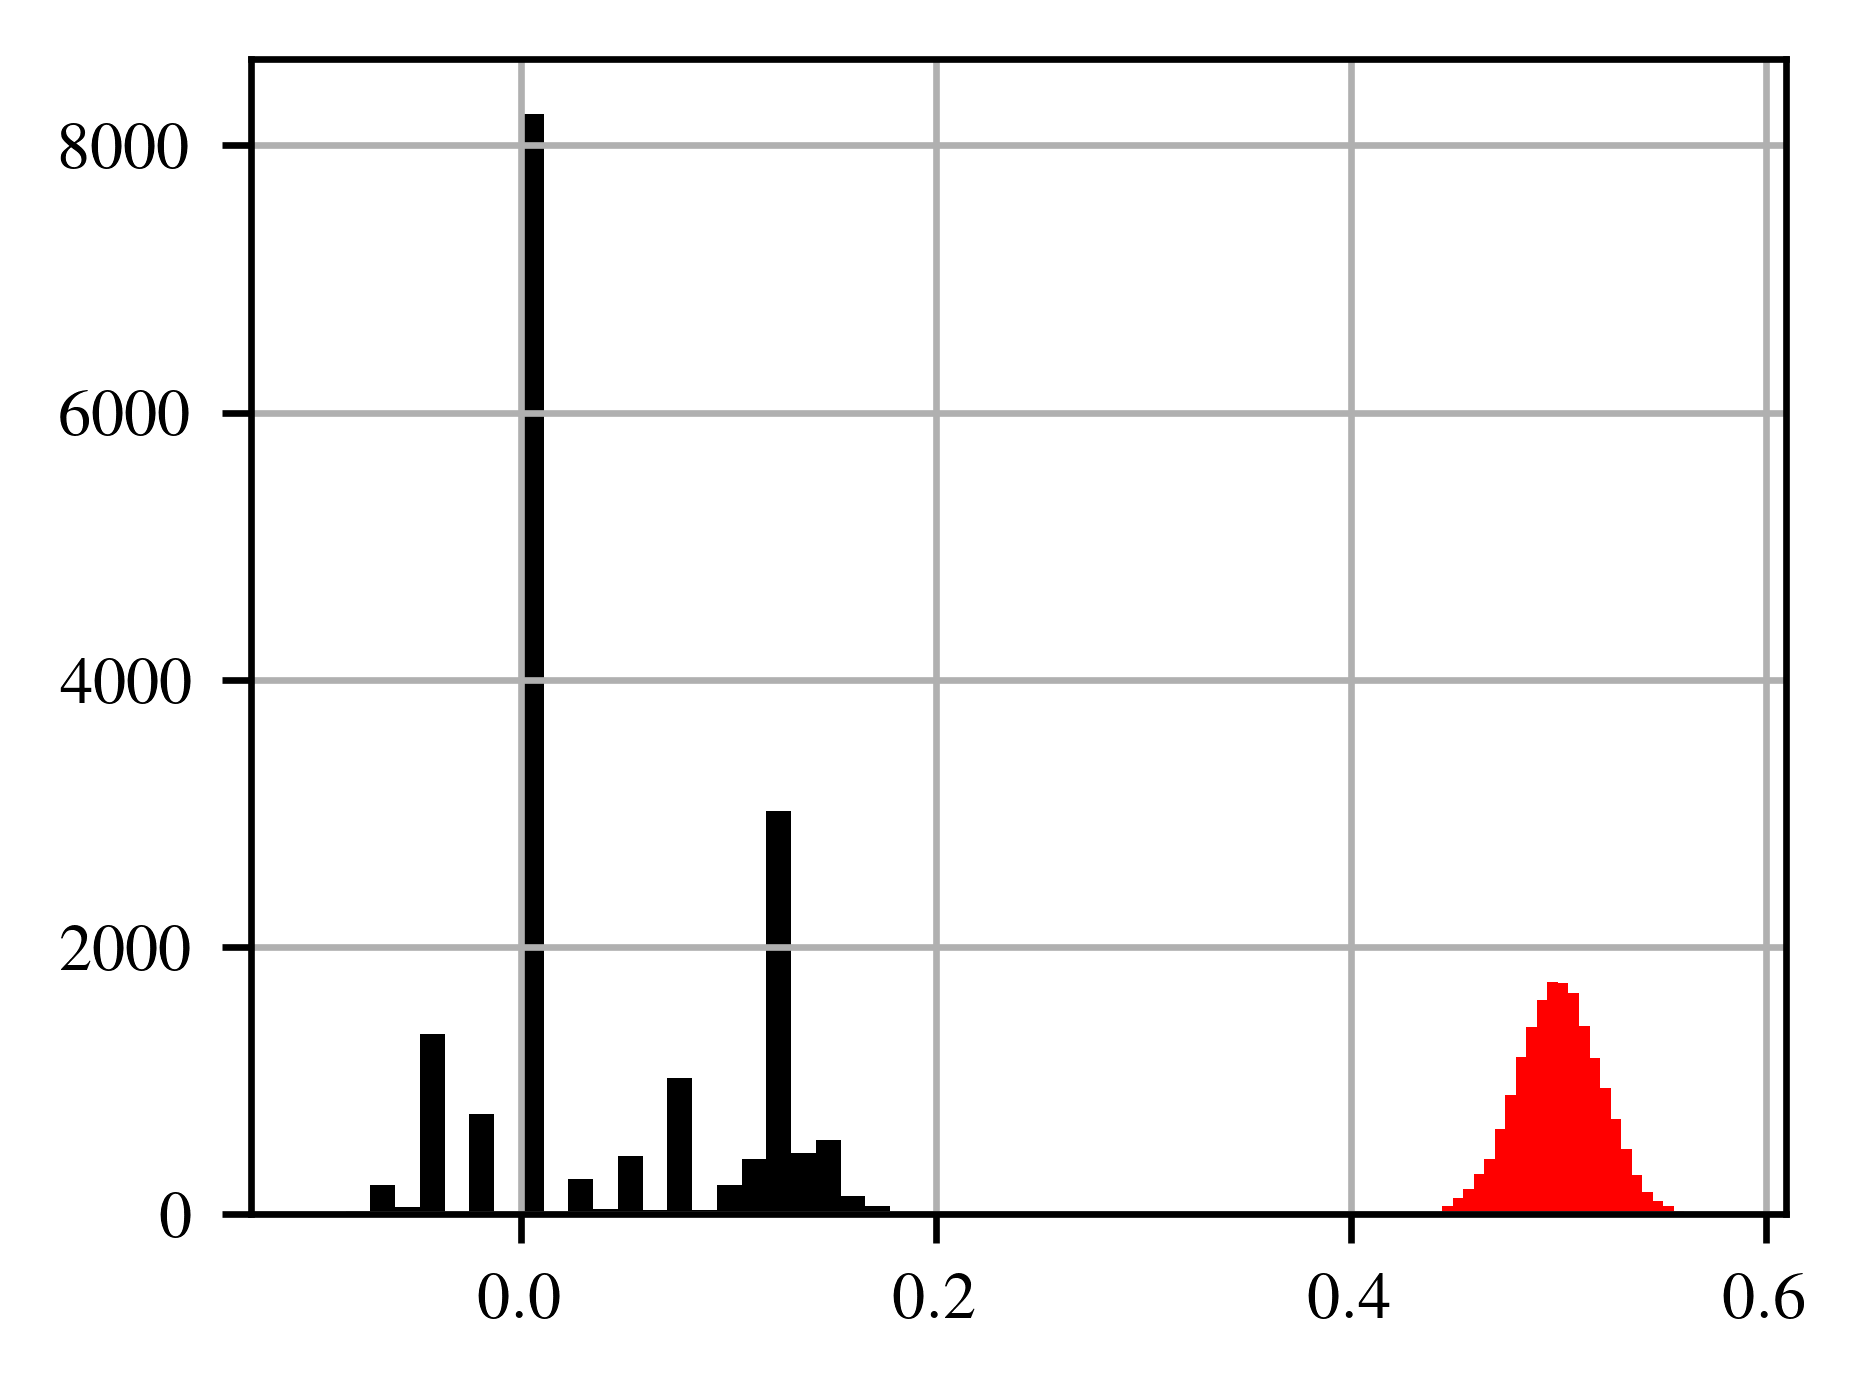

In [16]:
sse.ict2(scaler=1)
sse.ev["ict"].hist(bins=30)
sse.ev["tt"].hist(bins=30)

<AxesSubplot:>

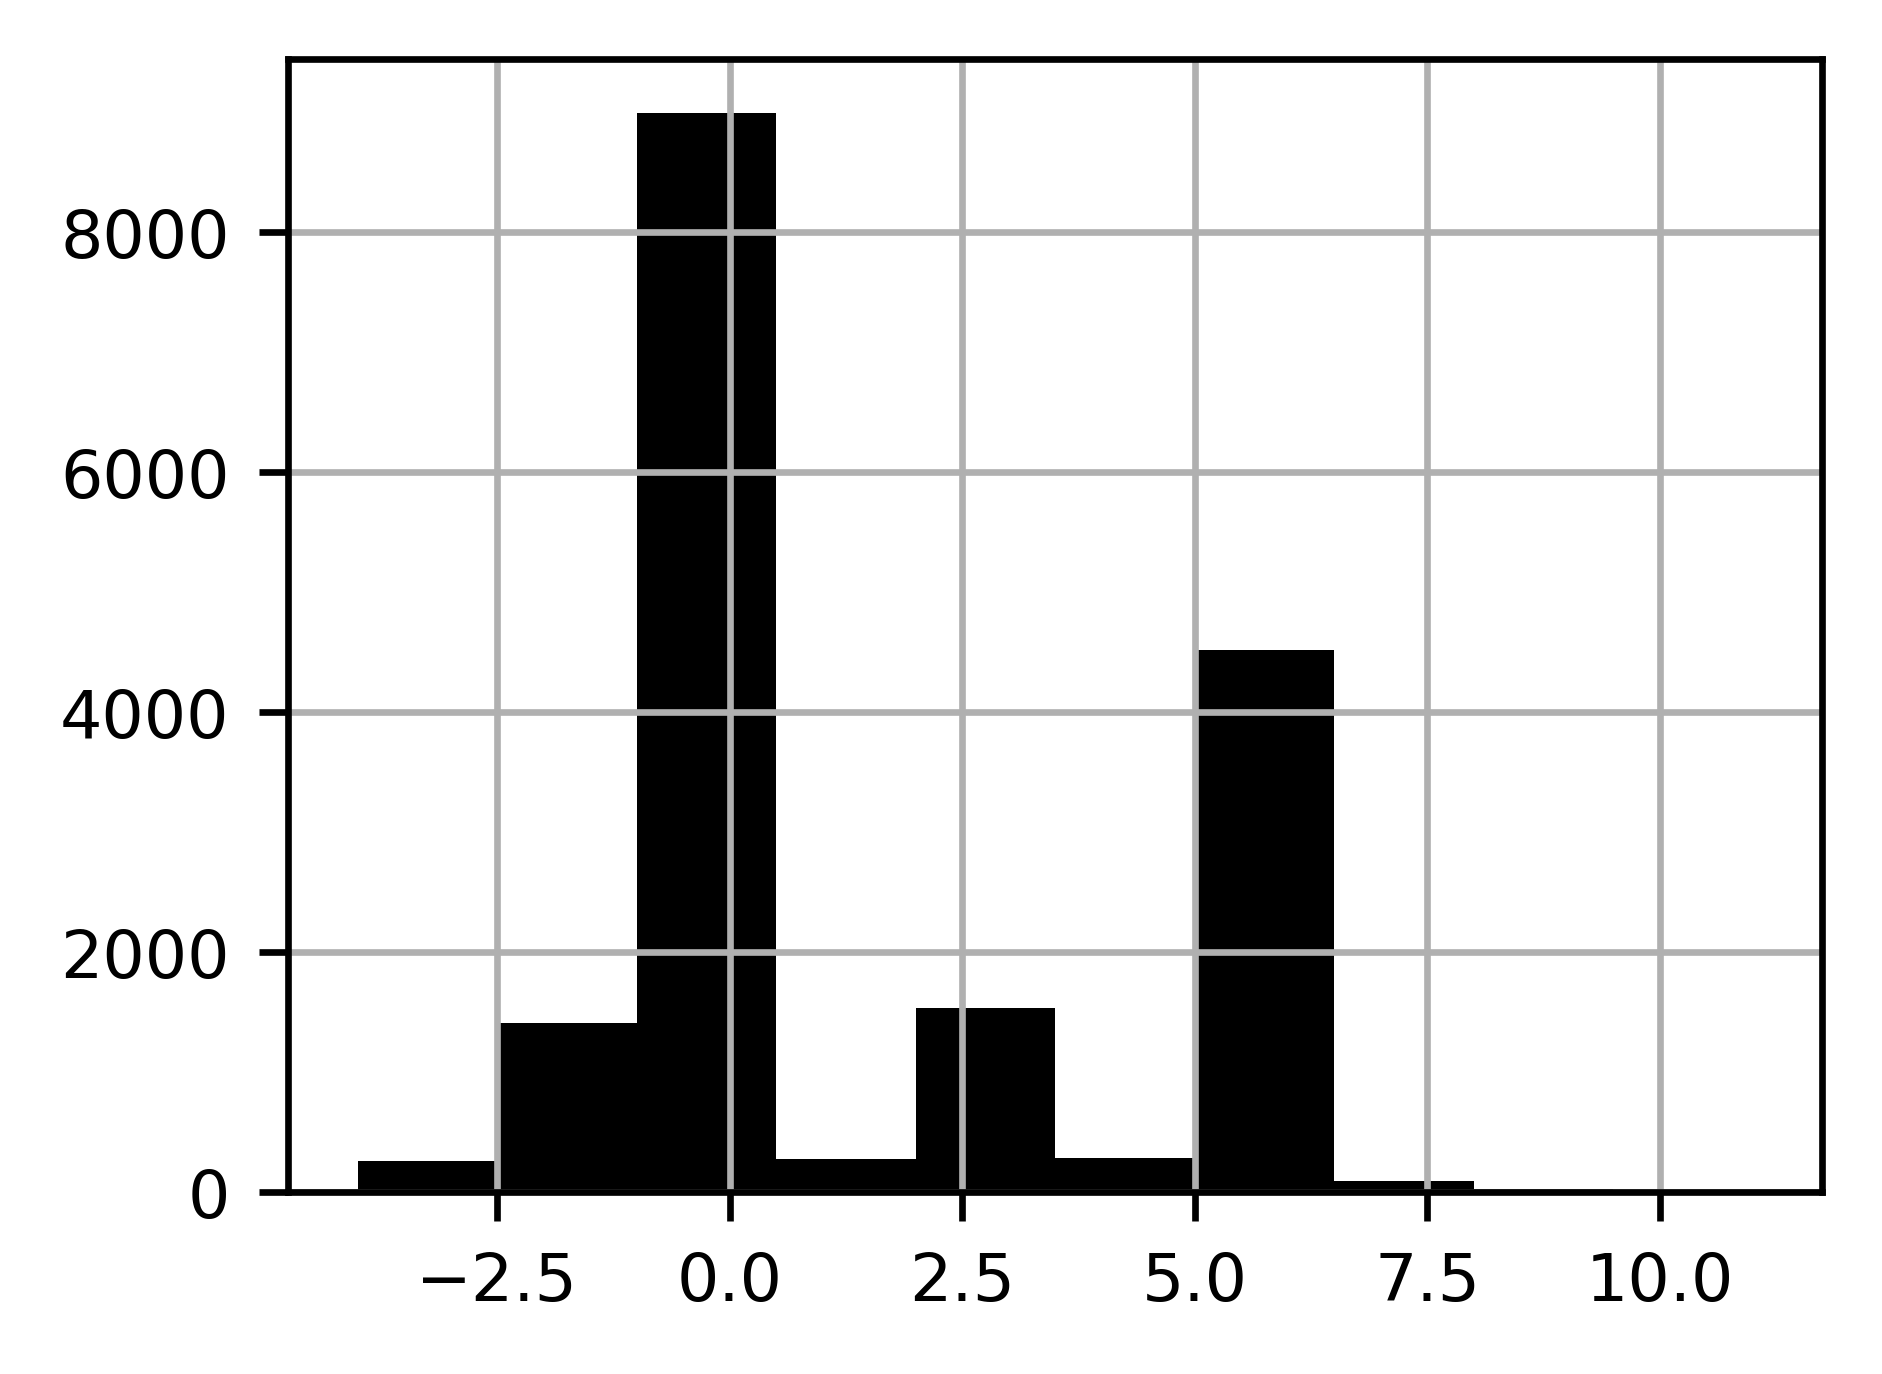

In [13]:
evc = sse.ev.copy()
evc['dna'] = evc['na'] - evc['na0']
evc['dna'].hist()

/home/jwang175/andes/jwang/notes/cosim_plot.py:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{np.round(i*100,0)}%' for i in np.arange(0, 1.1, 0.2)])


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (12).

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


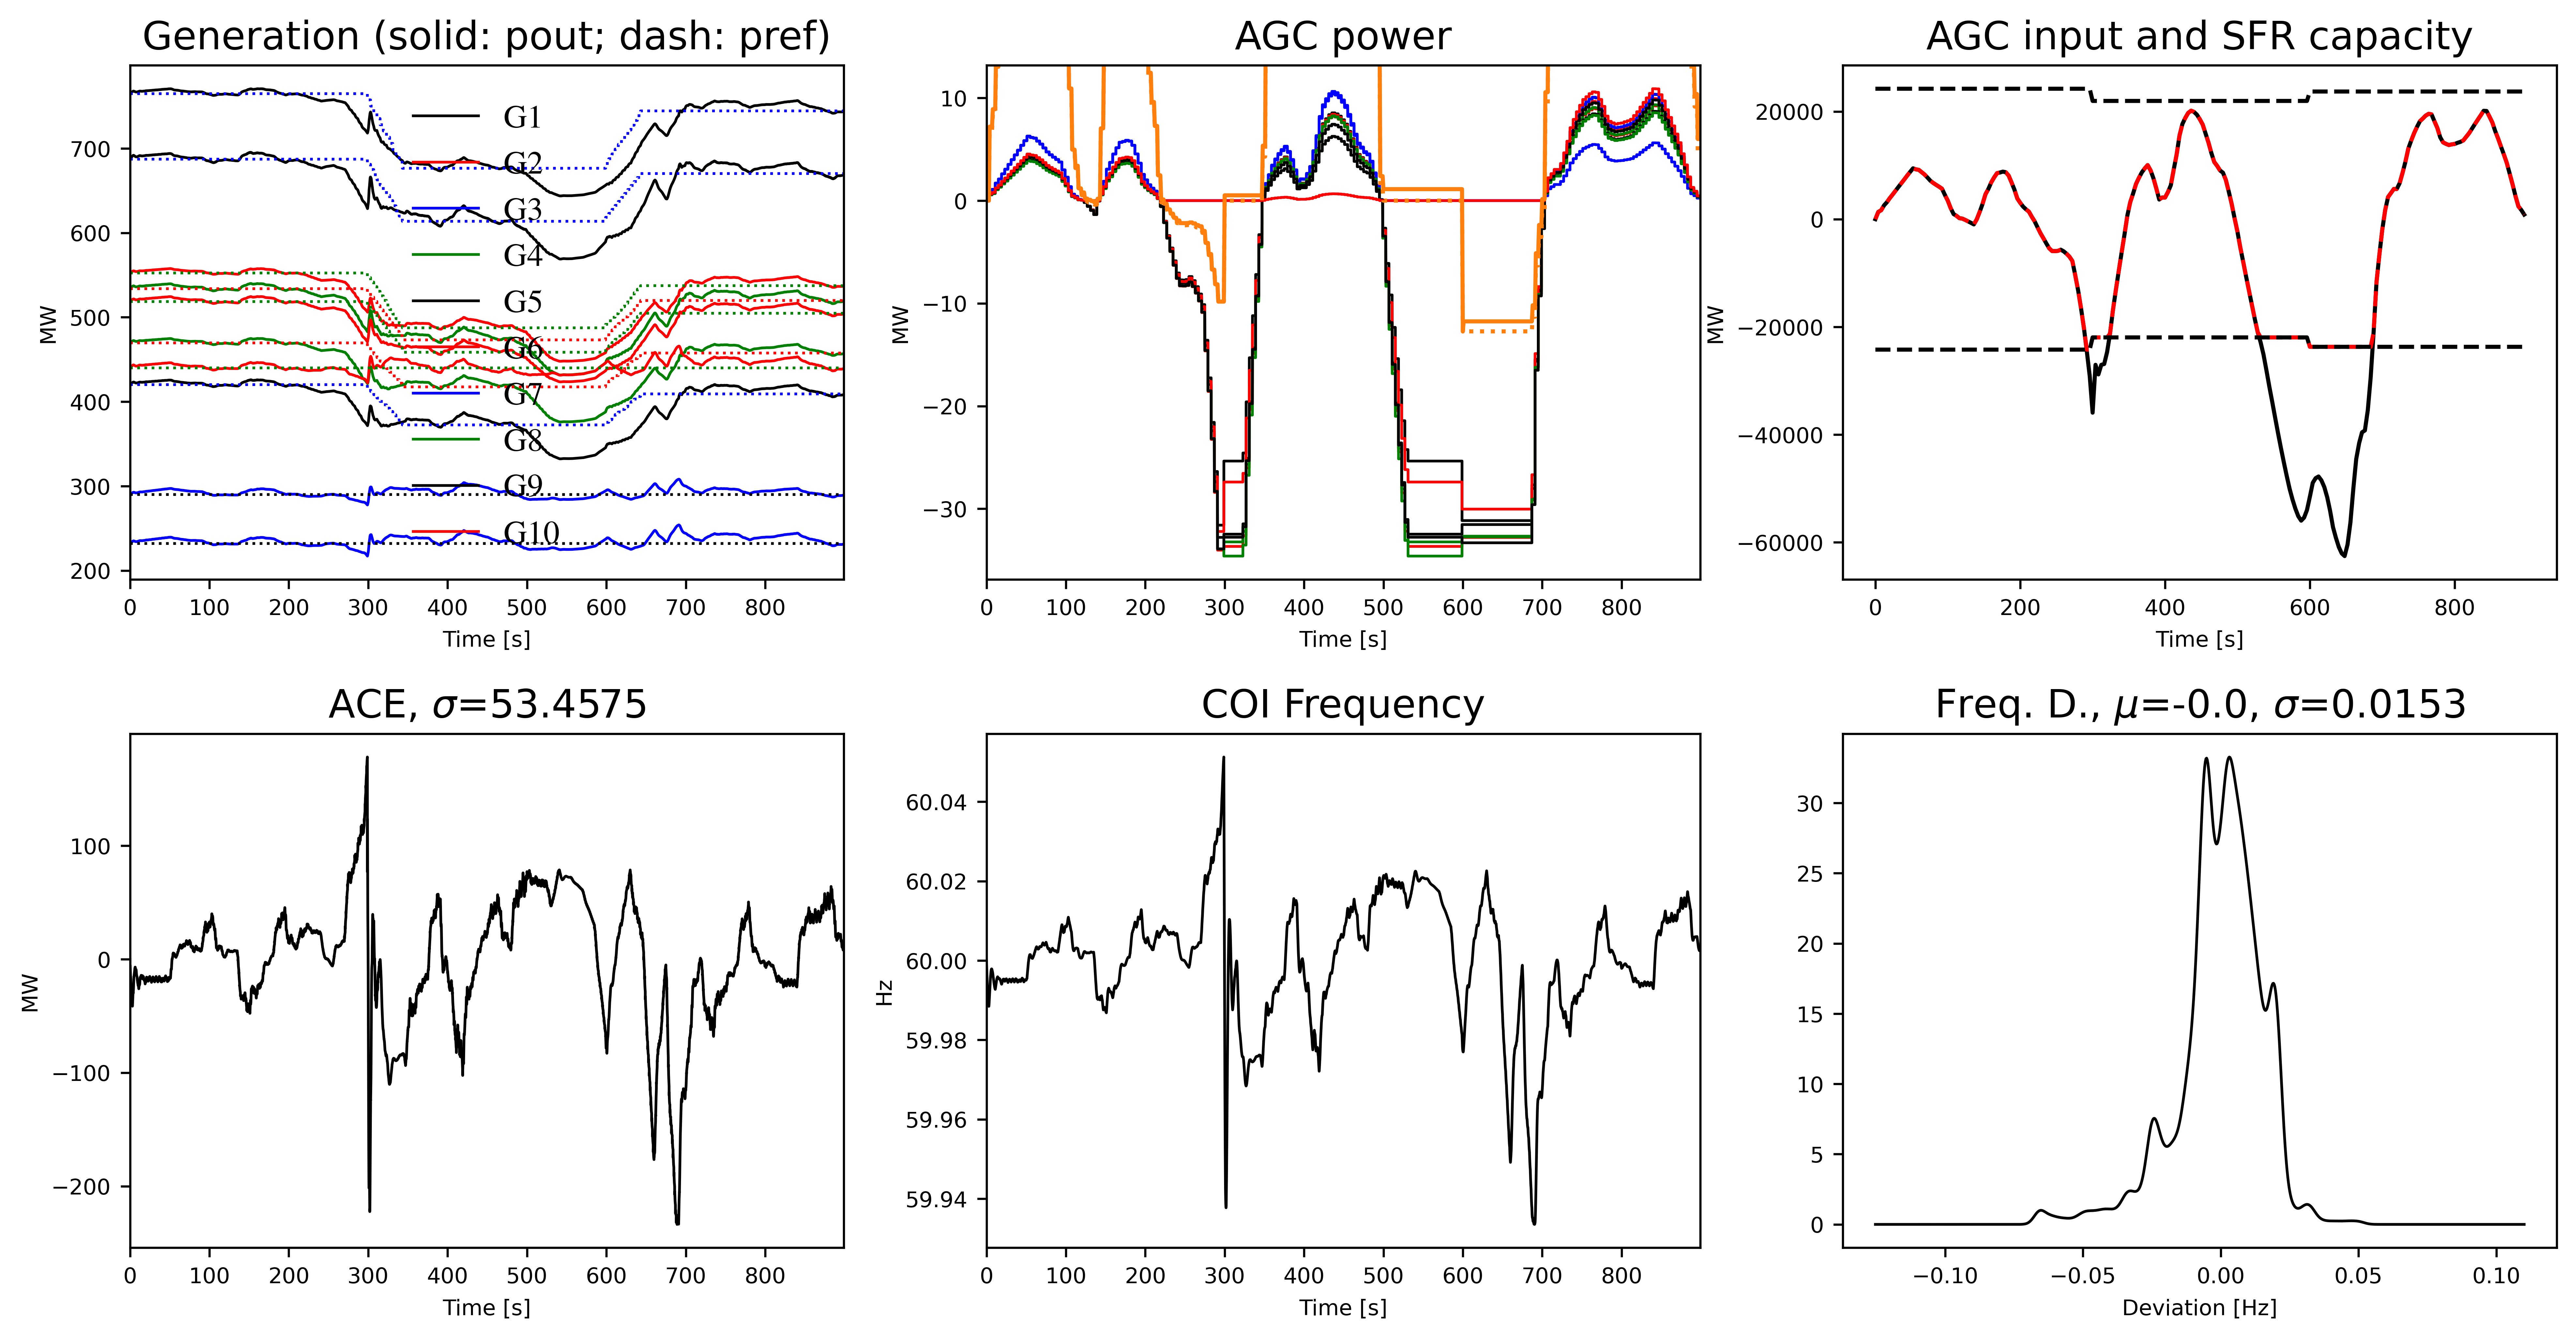

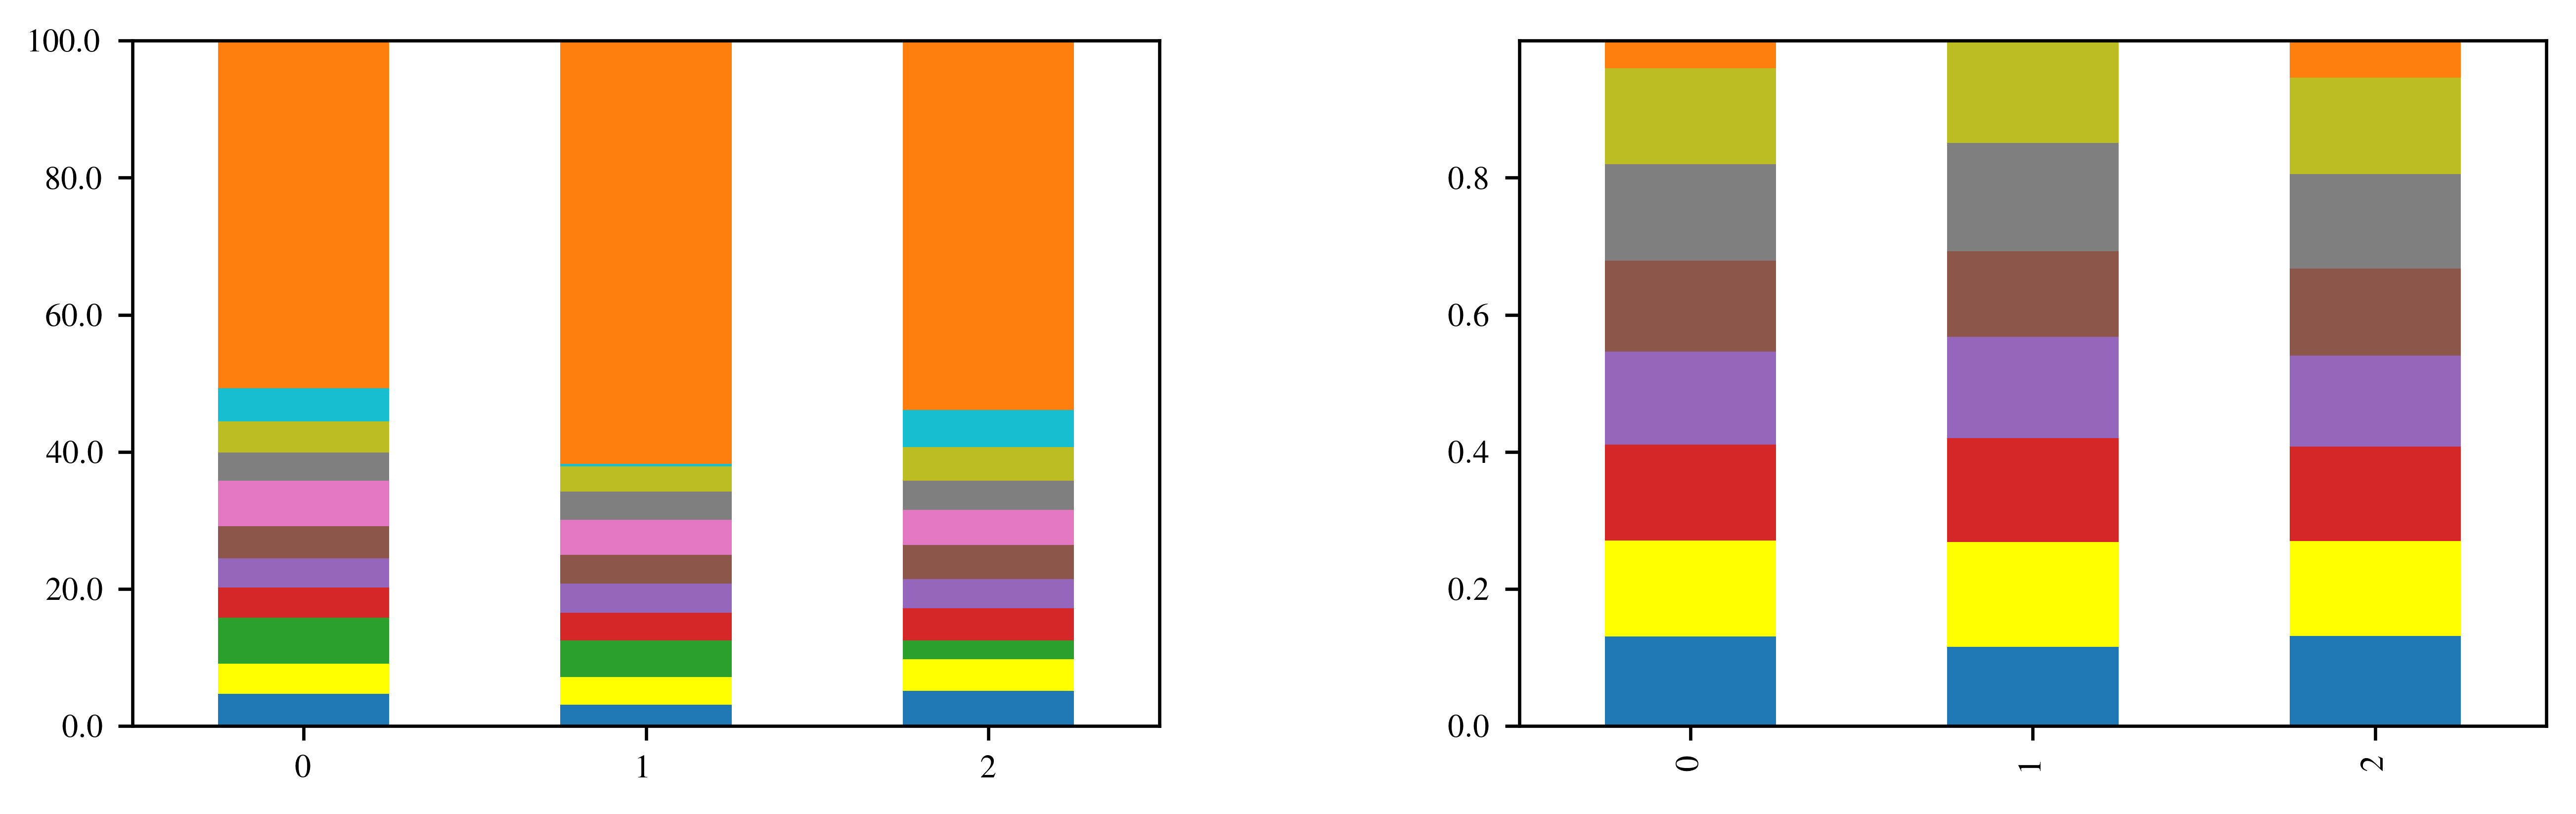

In [14]:
%run -i 'cosim_plot.py'

In [15]:
# split -l 4 index.txt split_file
# !ls -lh

plt.style.use('science')
%run -i 'cosim_plotev.py'